### Import Libraries

In [ ]:
!unzip /content/drive/"My Drive"/"Arrythmia "/ECGDataDenoised.zip

In [2]:
!pip install -q -U tensorflow_addons
!pip install neurokit2
# !pip install wfdb

     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [41]:
import sys
import os
%matplotlib inline
sampling_rate=500
arr_folder_location = "/content/drive/MyDrive/Arrythmia /"
sys.path.append(os.path.abspath(arr_folder_location))

In [4]:
from arryhthmia_backend import *

File Import Success


In [20]:
def extractor(case,id):
  cnt_id={}
  nsr_det_rri = []
  nsr_det_rri = np.array(nsr_det_rri)
  afib_det_rri = []
  afib_det_rri = np.array(afib_det_rri)
  afl_det_rri = []
  afl_det_rri = np.array(afl_det_rri)
  afl_list = []
  for i in id:
    label=subject_label[all_subjects[i]]
    if label in cnt_id:
      cnt_id[label]+=1
    else:
      cnt_id[label]=1
    name=all_subjects[i]
    if(label=='nsr'):
      nsr_det_rri=np.append(nsr_det_rri,nsr_rri[name])
    elif(label=='afl'):
      afl_list.append(name)
      afl_det_rri=np.append(afl_det_rri,afl_rri[name])
    else:
      afib_det_rri=np.append(afib_det_rri,afib_rri[name])
    ## 
  print(case,":",cnt_id)
  print(len(afib_det_rri),len(nsr_det_rri),len(afl_det_rri))

  p1 = np.random.permutation(afl_list)
  p2 = np.random.permutation(afl_list)
  # print(len(p1)," , ",len(p2))
  for k in p1:
    afl_det_rri=np.append(afl_det_rri,afl_rri[k])
  for k in p2:
    afl_det_rri=np.append(afl_det_rri,afl_rri[k])
  print("After patient Scrambling:",len(afl_det_rri))


  afib_vectors = round_robin(afib_det_rri)
  afl_vectors = round_robin(afl_det_rri)
  nsr_vectors = round_robin(nsr_det_rri)
  len__puncture = min(len(afib_vectors),min(len(nsr_vectors),len(afl_vectors)))
  afib_vectors = afib_vectors[:len__puncture]
  afl_vectors = afl_vectors[:len__puncture]
  nsr_vectors = nsr_vectors[:len__puncture]

  afib_rr = pd.DataFrame(afib_vectors)
  afib_rr['label']='afib'
  nsr_rr = pd.DataFrame(nsr_vectors)
  nsr_rr['label']='nsr'
  afl_rr = pd.DataFrame(afl_vectors)
  afl_rr['label']='afl'

  full_data_with_rr=pd.concat([afib_rr,nsr_rr,afl_rr])
  dict = {'nsr': 0, 'afib': 1, 'afl':2}
  full_data_with_rr.replace({'label': dict},inplace=True)
  return full_data_with_rr



def train_1_fold(train,test,NN,num_epochs):
    # train=pd.read_csv("/content/drive/MyDrive/train_with_rr_20.csv")
    train = train.sample(frac=1).reset_index(drop=True)
    train = train.sample(frac=1).reset_index(drop=True)
    full_data_with_rr=train
    full_test_set=test

    X_arhy_train, X_arhy_val, y_arhy_train, y_arhy_val = train_test_split(full_data_with_rr.iloc[:,:-1].values, full_data_with_rr.iloc[:,-1].values,test_size=0.1, random_state=42)

    X_arhy_test, X_arhy_val, y_arhy_test, y_arhy_val = train_test_split(X_arhy_val,y_arhy_val,test_size=0.5, random_state=42)

    # The 1D convolutions expect an extra dimension in the input data 
    X_arhyl_train = np.expand_dims(X_arhy_train, -1)
    y_arhyl_train = np.expand_dims(y_arhy_train, -1)
    X_arhyl_val = np.expand_dims(X_arhy_val, -1)
    y_arhyl_val = np.expand_dims(y_arhy_val, -1)
    X_arhyl_test = np.expand_dims(X_arhy_test, -1)
    y_arhyl_test = np.expand_dims(y_arhy_test, -1)

    N = X_arhyl_train.shape[0]
    batch_size = 128
    iterations = N/batch_size
    step_size= 2 * iterations

    optimizer = keras.optimizers.Adam(lr=0.001)
    model = get_resnet_model(5) 
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-02, max_steps=50, smoothing=0.6)
    _ = model.fit(X_arhyl_train, y_arhyl_train, batch_size=256, epochs=num_epochs, callbacks=[lr_finder], verbose=False)
    lr_finder.plot()

    lr_schedule = CyclicalLearningRate(1e-5, 1e-2, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
    
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    m_resnet_model = get_resnet_model(NN)

    save_best_weights = ModelCheckpoint(filepath="/content/drive/My Drive/Arrythmia /weights.hdf5", verbose=0, save_best_only=True)

    m_resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = m_resnet_model.fit(X_arhyl_train, y_arhyl_train, validation_data=(X_arhyl_val, y_arhyl_val), 
                                shuffle=True, batch_size=128, epochs=num_epochs, callbacks=[save_best_weights])
    pretty_plot(history, 'loss', lambda x: np.argmin(x))
    pretty_plot(history, 'accuracy', lambda x: np.argmax(x))
    m_resnet_model.load_weights("/content/drive/My Drive/Arrythmia /weights.hdf5")
    print("\n****** Val data (used to tune hyperparameters for model) *****\n")
    test_stats = m_resnet_model.evaluate(X_arhyl_test, y_arhyl_test)   
    test_acc = round(test_stats[1],2)
    
    y_pred = tf.argmax(m_resnet_model.predict(X_arhyl_test), axis=-1)
    # Compute confusion matrix
    cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['NSR', 'AFIB','AFL'],
                        title='Confusion matrix, without normalization')

    X_arhy_test_10split = full_test_set.iloc[:,:-1].values
    y_arhy_test_10split = full_test_set.iloc[:,-1].values

    print("\n****** Validation data (unseen to model) *****\n")
    ###########
    val_stats=m_resnet_model.evaluate(X_arhy_test_10split, y_arhy_test_10split)
    val_acc = round(val_stats[1],4)
    
    y_pred = tf.argmax(m_resnet_model.predict(X_arhy_test_10split), axis=-1)
    # Compute confusion matrix
    cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test_10split, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['NSR', 'AFIB','AFL'],
                        title='Confusion matrix, without normalization')
    
    print("Final Accuracy:",val_acc*100,"%\n")
    return float(val_acc*100)


In [6]:
labels = pd.read_excel('/content/drive/MyDrive/Arrythmia /Diagnostics.xlsx')
len(labels)

10646

In [7]:
labels=labels[(labels['Rhythm']=='AFIB') | (labels['Rhythm']=='AF') |(labels['Rhythm']=='SR')]
labels.reset_index(inplace=True,drop=True)
labels['Rhythm'].value_counts()

SR      1826
AFIB    1780
AF       445
Name: Rhythm, dtype: int64

### Preprocessing

In [8]:
afib_files = labels[labels['Rhythm']=="AFIB"]['FileName'].tolist()
afib_files.remove('MUSE_20180116_131253_72000')
nsr_files = labels[labels['Rhythm']=="SR"]['FileName'].tolist()
afl_files = labels[labels['Rhythm']=="AF"]['FileName'].tolist()
all_files = afib_files+nsr_files+afl_files

In [9]:
nsr_rri=append_r_peaks(nsr_files,"nsr",sampling_rate=500)
afib_rri=append_r_peaks(afib_files,"afib",sampling_rate=500)
afl_rri=append_r_peaks(afl_files,"afl",sampling_rate=500)
# to verify total no. of total RR Intervals for each class and 
# Extract RR Peaks into a dictionary with filename

100%|██████████| 1826/1826 [00:29<00:00, 62.77it/s]


Total no. of RR Intervals in nsr  class is: 20520 



 91%|█████████ | 1620/1779 [00:28<00:03, 52.53it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1779/1779 [00:31<00:00, 55.70it/s]


Total no. of RR Intervals in afib  class is: 25124 



100%|██████████| 445/445 [00:08<00:00, 54.52it/s]

Total no. of RR Intervals in afl  class is: 7491 



In [10]:
# nsr_extraction_rr = pd.DataFrame.from_dict(nsr_rri,orient='index')
# afl_extraction_rr = pd.DataFrame.from_dict(afl_rri,orient='index')
# afib_extraction_rr = pd.DataFrame.from_dict(afib_rri,orient='index')

In [11]:
all_subjects=all_files
subject_label = {}
for i in afib_files:
    subject_label[i] = 'afib'
for i in nsr_files:
    subject_label[i] = 'nsr'
for i in afl_files:
    subject_label[i] = 'afl'

In [12]:
# import BatchNormalization
from tensorflow.keras.layers import BatchNormalization

In [17]:
# model_m = Sequential()
# input_shape=(100,1)
# model_m.add(Reshape(input_shape))
# model_m.add(Conv1D(64,8, activation='relu'))
# model_m.add(Conv1D(100, 10, activation='relu'))
# model_m.add(MaxPooling1D(3))
# model_m.add(Conv1D(160, 10, activation='relu'))
# model_m.add(Conv1D(160, 10, activation='relu'))
# model_m.add(GlobalAveragePooling1D())
# model_m.add(Dropout(0.5))
# model_m.add(Dense(num_classes, activation='softmax'))
# print(model_m.summary())

### Labelling encoding {'nsr': 0, 'afib': 1, 'afl':2}


In [99]:
def get_resnet_model(categories=3): #original
  def residual_block(X, kernels, stride,F_size):
    out = tf.keras.layers.Conv1D(F_size,kernels, stride, padding='same')(X)
    # out = tf.keras.layers.BatchNormalization()
    out = tf.keras.activations.relu(out)
    # out = tf.keras.activations.sigmoid(out)
    
    out = tf.keras.layers.add([X, out])
    out = tf.keras.layers.MaxPool1D(1, 3)(out)
    return out

  kernels = 32
  stride = 1

  ### INPUT
  inputs = tf.keras.layers.Input([100,1])
  ### BLOCK 1
  X = tf.keras.layers.Conv1D(64,8, stride)(inputs)  
  X = tf.keras.activations.relu(X)
  X = tf.keras.layers.Conv1D(64,5, stride)(inputs)  
  X = tf.keras.activations.relu(X)
  X = tf.keras.layers.Conv1D(64,3, stride)(inputs)  
  X = tf.keras.activations.relu(X)

  ### Residual Block
  X = residual_block(X, kernels, stride,64)
  X = tf.keras.activations.relu(X)  

  ### BLOCK 2
  X = tf.keras.layers.Conv1D(128,8, stride)(inputs)
  X = tf.keras.activations.relu(X)
  X = tf.keras.layers.Conv1D(128,5, stride)(inputs)
  X = tf.keras.activations.relu(X)
  X = tf.keras.layers.Conv1D(128,3, stride)(inputs)
  X = tf.keras.activations.relu(X)

  ### Residual Block  
  X = residual_block(X, kernels, stride,128)
  X = tf.keras.activations.relu(X)  

  ### BLOCK 3
  X = tf.keras.layers.Conv1D(128,8, stride)(inputs)
  X = tf.keras.activations.relu(X)
  X = tf.keras.layers.Conv1D(128,5, stride)(inputs)
  X = tf.keras.activations.relu(X)
  X = tf.keras.layers.Conv1D(128,3, stride)(inputs)
  X = tf.keras.activations.relu(X)
  
  ### Residual Block  
  X = residual_block(X, kernels, stride,128)
  
  X = tf.keras.layers.Flatten()(X)
  X = tf.keras.layers.Dense(64, activation='relu')(X)
  X = tf.keras.layers.Dense(32, activation='relu')(X)
  X = tf.keras.layers.Dense(8, activation='relu')(X)

  output = (tf.keras.layers.Dense(1, activation='sigmoid')(X) if categories == 3 else tf.keras.layers.Dense(5, activation='softmax')(X))

  model = tf.keras.Model(inputs=inputs, outputs=output)
  return model


train : {'afib': 1592, 'nsr': 1652, 'afl': 401}
22573 18567 6786
After patient Scrambling: 20358


100%|██████████| 18567/18567 [00:00<00:00, 30837.08it/s]


test : {'afib': 187, 'nsr': 174, 'afl': 44}
2551 1953 705
After patient Scrambling: 2115


100%|██████████| 1953/1953 [00:00<00:00, 810154.85it/s]



#@#@#@#@#@ Working on FOLD: 1 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
392/392 [==============================] - 5s 12ms/step - loss: 0.5099 - accuracy: 0.7758 - val_loss: 0.2033 - val_accuracy: 0.9214
Epoch 2/8
392/392 [==============================] - 4s 11ms/step - loss: 0.1935 - accuracy: 0.9269 - val_loss: 0.1224 - val_accuracy: 0.9562
Epoch 3/8
392/392 [==============================] - 4s 11ms/step - loss: 0.0877 - accuracy: 0.9690 - val_loss: 0.0224 - val_accuracy: 0.9928
Epoch 4/8
392/392 [==============================] - 4s 11ms/step - loss: 0.0159 - accuracy: 0.9946 - val_loss: 0.0053 - val_accuracy: 0.9982
Epoch 5/8
392/392 [==============================] - 4s 11ms/step - loss: 0.0084 - accuracy: 0.9974 - val_loss: 0.0347 - val_accuracy: 0.9889
Epoch 6/8
392/392 [==============================] - 4s 10ms/step - loss: 0.0654 - accuracy: 0.9793 - val_loss: 0.0411 - val_accuracy: 0.9867
Epoch 7/8
392/392 [==============================] - 4s 11ms/step - loss: 0.0150 - accuracy: 0.9953 - val_loss: 0.0098 - val_accuracy: 0.9968
Epoch 

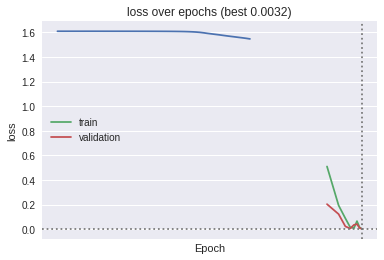

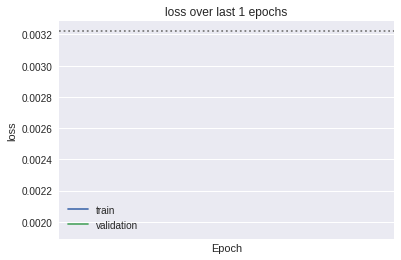

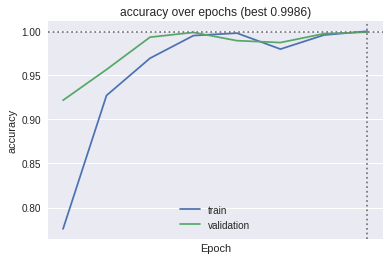

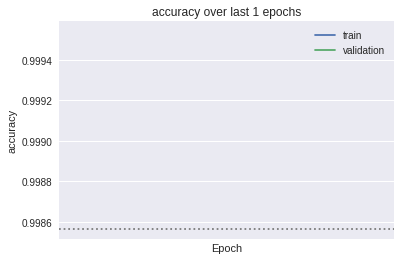


****** Val data (used to tune hyperparameters for model) *****

88/88 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 0.9993
Confusion matrix, without normalization
[[906   0   0]
 [  0 962   0]
 [  1   1 915]]

****** Validation data (unseen to model) *****

184/184 [==============================] - 1s 4ms/step - loss: 0.0956 - accuracy: 0.9776
Confusion matrix, without normalization
[[1952    0    1]
 [   0 1923   30]
 [  17   83 1853]]
Final Accuracy: 97.76 %

train : {'afib': 1587, 'nsr': 1650, 'afl': 408}
22383 18526 6843
After patient Scrambling: 20529


100%|██████████| 18526/18526 [00:00<00:00, 69281.60it/s]


test : {'afib': 192, 'nsr': 176, 'afl': 37}
2741 1994 648
After patient Scrambling: 1944


100%|██████████| 1994/1994 [00:00<00:00, 496700.45it/s]



#@#@#@#@#@ Working on FOLD: 2 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
391/391 [==============================] - 5s 12ms/step - loss: 0.5890 - accuracy: 0.6992 - val_loss: 0.1678 - val_accuracy: 0.9410
Epoch 2/8
391/391 [==============================] - 4s 11ms/step - loss: 0.1353 - accuracy: 0.9517 - val_loss: 0.0688 - val_accuracy: 0.9777
Epoch 3/8
391/391 [==============================] - 4s 11ms/step - loss: 0.0574 - accuracy: 0.9813 - val_loss: 0.0160 - val_accuracy: 0.9942
Epoch 4/8
391/391 [==============================] - 4s 11ms/step - loss: 0.0064 - accuracy: 0.9982 - val_loss: 0.0038 - val_accuracy: 0.9986
Epoch 5/8
391/391 [==============================] - 4s 10ms/step - loss: 0.0038 - accuracy: 0.9988 - val_loss: 0.0264 - val_accuracy: 0.9903
Epoch 6/8
391/391 [==============================] - 4s 11ms/step - loss: 0.0235 - accuracy: 0.9928 - val_loss: 0.0456 - val_accuracy: 0.9860
Epoch 7/8
391/391 [==============================] - 5s 12ms/step - loss: 0.0174 - accuracy: 0.9947 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 

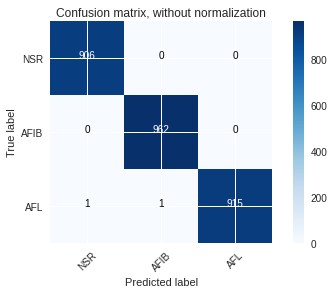

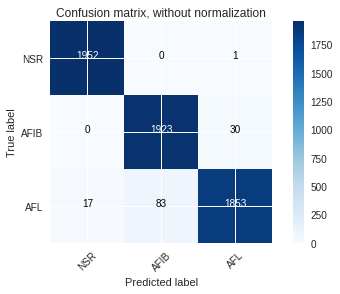

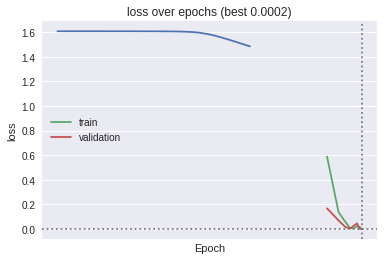

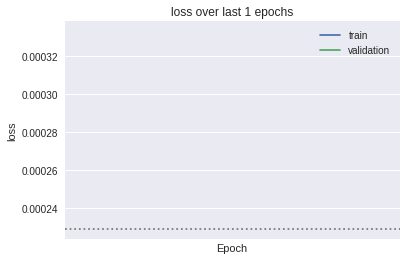

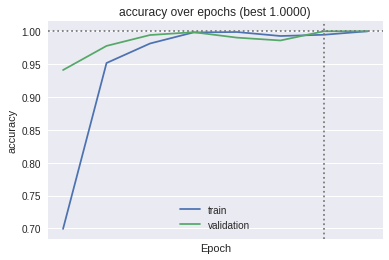

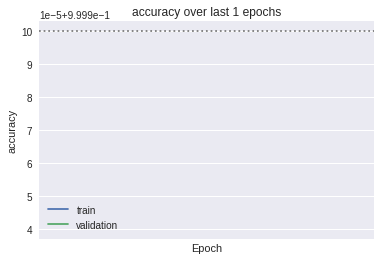


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 3ms/step - loss: 0.0019 - accuracy: 0.9996
Confusion matrix, without normalization
[[921   0   0]
 [  0 941   0]
 [  0   1 916]]

****** Validation data (unseen to model) *****

183/183 [==============================] - 1s 4ms/step - loss: 0.2063 - accuracy: 0.9624
Confusion matrix, without normalization
[[1910    0   34]
 [   0 1821  123]
 [  12   50 1882]]
Final Accuracy: 96.24000000000001 %

train : {'afib': 1598, 'nsr': 1646, 'afl': 401}
22544 18493 6771
After patient Scrambling: 20313


100%|██████████| 18493/18493 [00:00<00:00, 469225.15it/s]


test : {'afib': 181, 'nsr': 180, 'afl': 44}
2580 2027 720
After patient Scrambling: 2160


100%|██████████| 2027/2027 [00:00<00:00, 817093.15it/s]



#@#@#@#@#@ Working on FOLD: 3 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
391/391 [==============================] - 5s 12ms/step - loss: 0.4431 - accuracy: 0.8129 - val_loss: 0.2177 - val_accuracy: 0.9218
Epoch 2/8
391/391 [==============================] - 4s 11ms/step - loss: 0.1800 - accuracy: 0.9376 - val_loss: 0.1524 - val_accuracy: 0.9484
Epoch 3/8
391/391 [==============================] - 4s 11ms/step - loss: 0.0888 - accuracy: 0.9690 - val_loss: 0.0504 - val_accuracy: 0.9838
Epoch 4/8
391/391 [==============================] - 4s 11ms/step - loss: 0.0152 - accuracy: 0.9952 - val_loss: 0.0095 - val_accuracy: 0.9968
Epoch 5/8
391/391 [==============================] - 4s 11ms/step - loss: 0.0072 - accuracy: 0.9980 - val_loss: 0.0372 - val_accuracy: 0.9856
Epoch 6/8
391/391 [==============================] - 4s 11ms/step - loss: 0.0424 - accuracy: 0.9858 - val_loss: 0.0253 - val_accuracy: 0.9928
Epoch 7/8
391/391 [==============================] - 4s 11ms/step - loss: 0.0151 - accuracy: 0.9948 - val_loss: 0.0125 - val_accuracy: 0.9957
Epoch 

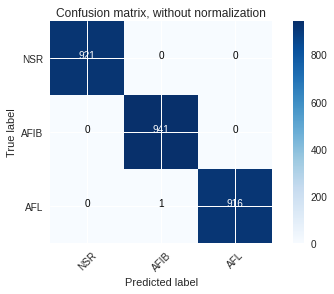

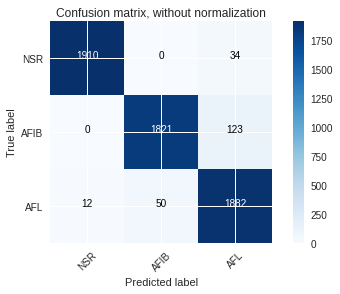

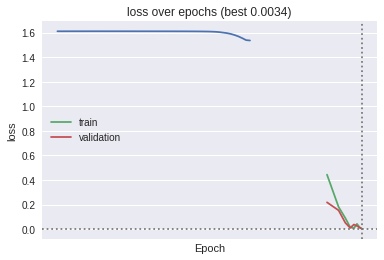

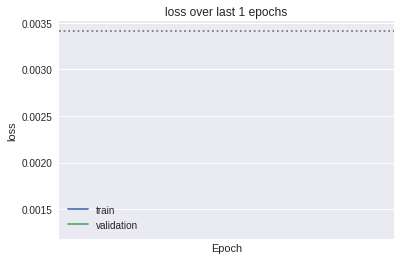

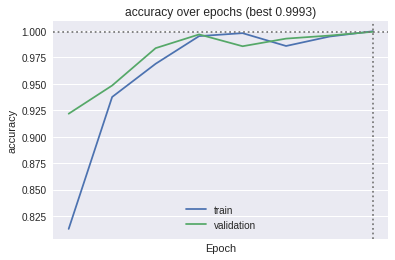

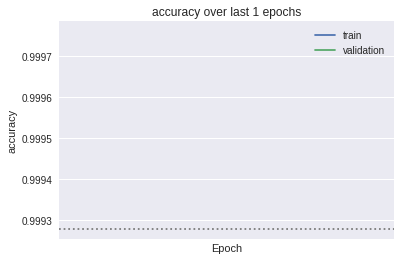


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 0.9993
Confusion matrix, without normalization
[[920   0   0]
 [  0 943   0]
 [  2   0 909]]

****** Validation data (unseen to model) *****

191/191 [==============================] - 1s 5ms/step - loss: 0.3697 - accuracy: 0.9472
Confusion matrix, without normalization
[[1858    0  169]
 [   0 2015   12]
 [  79   61 1887]]
Final Accuracy: 94.72 %

train : {'afib': 1601, 'nsr': 1647, 'afl': 397}
22597 18505 6601
After patient Scrambling: 19803


100%|██████████| 18505/18505 [00:00<00:00, 307043.15it/s]


test : {'afib': 178, 'nsr': 179, 'afl': 48}
2527 2015 890
After patient Scrambling: 2670


100%|██████████| 2015/2015 [00:00<00:00, 703063.19it/s]


#@#@#@#@#@ Working on FOLD: 4 #@#@#@#@#@




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
391/391 [==============================] - 7s 15ms/step - loss: 0.5647 - accuracy: 0.7240 - val_loss: 0.1655 - val_accuracy: 0.9355
Epoch 2/8
391/391 [==============================] - 5s 12ms/step - loss: 0.2571 - accuracy: 0.9057 - val_loss: 0.1505 - val_accuracy: 0.9474
Epoch 3/8
391/391 [==============================] - 5s 12ms/step - loss: 0.0946 - accuracy: 0.9670 - val_loss: 0.0634 - val_accuracy: 0.9777
Epoch 4/8
391/391 [==============================] - 5s 12ms/step - loss: 0.0369 - accuracy: 0.9870 - val_loss: 0.0341 - val_accuracy: 0.9881
Epoch 5/8
391/391 [==============================] - 5s 12ms/step - loss: 0.0277 - accuracy: 0.9905 - val_loss: 0.0332 - val_accuracy: 0.9874
Epoch 6/8
391/391 [==============================] - 5s 13ms/step - loss: 0.0399 - accuracy: 0.9863 - val_loss: 0.0306 - val_accuracy: 0.9892
Epoch 7/8
391/391 [==============================] - 5s 12ms/step - loss: 0.0167 - accuracy: 0.9945 - val_loss: 0.0111 - val_accuracy: 0.9960
Epoch 

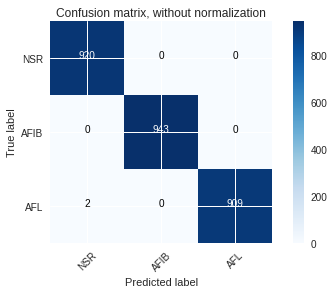

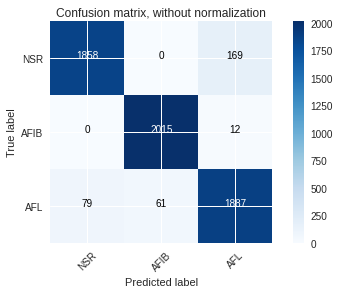

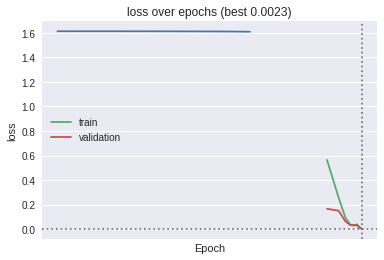

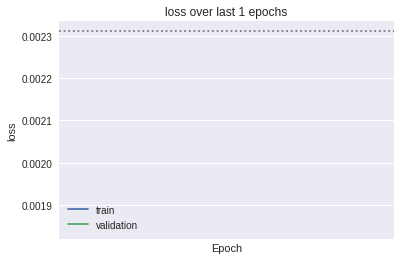

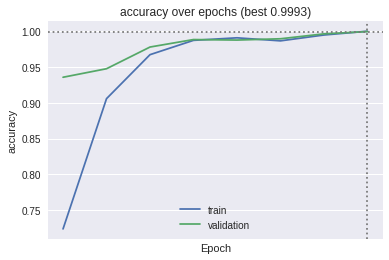

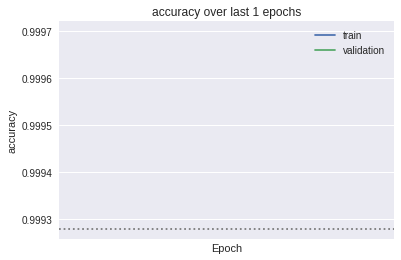


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 4ms/step - loss: 0.0040 - accuracy: 0.9993
Confusion matrix, without normalization
[[925   0   0]
 [  0 904   1]
 [  0   1 945]]

****** Validation data (unseen to model) *****

189/189 [==============================] - 1s 4ms/step - loss: 0.2586 - accuracy: 0.9598
Confusion matrix, without normalization
[[2015    0    0]
 [   0 1914  101]
 [  13  129 1873]]
Final Accuracy: 95.98 %

train : {'afib': 1612, 'nsr': 1639, 'afl': 394}
22717 18466 6641
After patient Scrambling: 19923


100%|██████████| 18466/18466 [00:00<00:00, 364265.81it/s]


test : {'afib': 167, 'nsr': 187, 'afl': 51}
2407 2054 850
After patient Scrambling: 2550


100%|██████████| 2054/2054 [00:00<00:00, 475762.12it/s]



#@#@#@#@#@ Working on FOLD: 5 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
390/390 [==============================] - 6s 13ms/step - loss: 0.5433 - accuracy: 0.7577 - val_loss: 0.1596 - val_accuracy: 0.9365
Epoch 2/8
390/390 [==============================] - 5s 12ms/step - loss: 0.1850 - accuracy: 0.9336 - val_loss: 0.1609 - val_accuracy: 0.9480
Epoch 3/8
390/390 [==============================] - 4s 11ms/step - loss: 0.0774 - accuracy: 0.9739 - val_loss: 0.0325 - val_accuracy: 0.9884
Epoch 4/8
390/390 [==============================] - 4s 11ms/step - loss: 0.0165 - accuracy: 0.9951 - val_loss: 0.0085 - val_accuracy: 0.9978
Epoch 5/8
390/390 [==============================] - 4s 11ms/step - loss: 0.0085 - accuracy: 0.9975 - val_loss: 0.0500 - val_accuracy: 0.9787
Epoch 6/8
390/390 [==============================] - 4s 11ms/step - loss: 0.0456 - accuracy: 0.9861 - val_loss: 0.0563 - val_accuracy: 0.9838
Epoch 7/8
390/390 [==============================] - 5s 12ms/step - loss: 0.0164 - accuracy: 0.9950 - val_loss: 0.0074 - val_accuracy: 0.9989
Epoch 

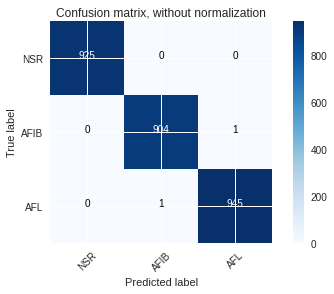

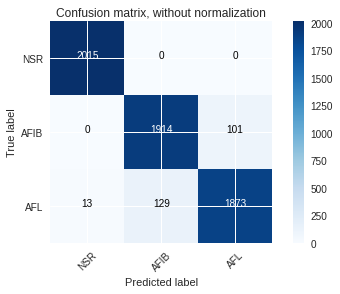

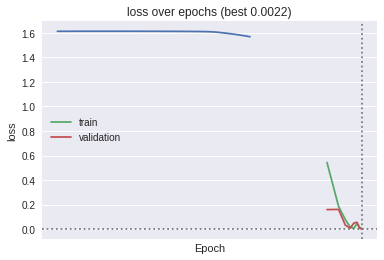

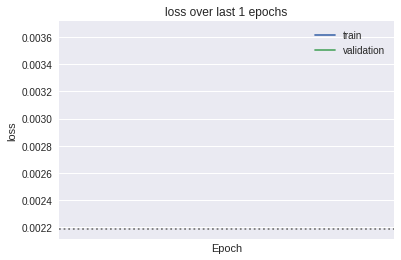

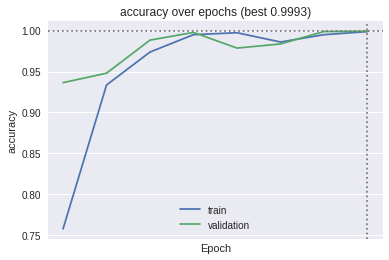

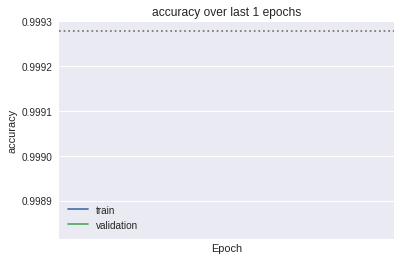


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 3ms/step - loss: 0.0026 - accuracy: 0.9989
Confusion matrix, without normalization
[[946   0   0]
 [  0 905   1]
 [  1   1 916]]

****** Validation data (unseen to model) *****

193/193 [==============================] - 1s 4ms/step - loss: 0.5247 - accuracy: 0.9111
Confusion matrix, without normalization
[[1955    0   99]
 [   0 1905  149]
 [ 236   64 1754]]
Final Accuracy: 91.11 %

train : {'afib': 1601, 'nsr': 1640, 'afl': 404}
22603 18418 6844
After patient Scrambling: 20532


100%|██████████| 18418/18418 [00:00<00:00, 357907.20it/s]


test : {'afib': 178, 'nsr': 186, 'afl': 41}
2521 2102 647
After patient Scrambling: 1941


100%|██████████| 2102/2102 [00:00<00:00, 405744.72it/s]



#@#@#@#@#@ Working on FOLD: 6 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
389/389 [==============================] - 6s 14ms/step - loss: 0.5417 - accuracy: 0.7554 - val_loss: 0.1471 - val_accuracy: 0.9529
Epoch 2/8
389/389 [==============================] - 4s 11ms/step - loss: 0.1342 - accuracy: 0.9556 - val_loss: 0.1185 - val_accuracy: 0.9620
Epoch 3/8
389/389 [==============================] - 4s 11ms/step - loss: 0.0485 - accuracy: 0.9840 - val_loss: 0.0173 - val_accuracy: 0.9949
Epoch 4/8
389/389 [==============================] - 4s 11ms/step - loss: 0.0093 - accuracy: 0.9972 - val_loss: 0.0065 - val_accuracy: 0.9975
Epoch 5/8
389/389 [==============================] - 5s 12ms/step - loss: 0.0096 - accuracy: 0.9970 - val_loss: 0.0187 - val_accuracy: 0.9917
Epoch 6/8
389/389 [==============================] - 4s 11ms/step - loss: 0.0308 - accuracy: 0.9901 - val_loss: 0.1102 - val_accuracy: 0.9747
Epoch 7/8
389/389 [==============================] - 4s 11ms/step - loss: 0.0262 - accuracy: 0.9923 - val_loss: 0.0157 - val_accuracy: 0.9942
Epoch 

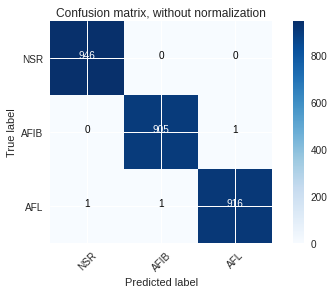

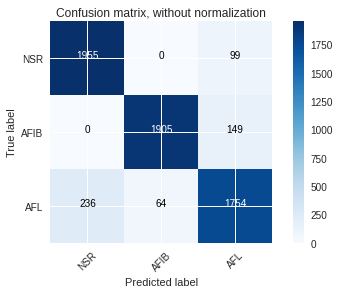

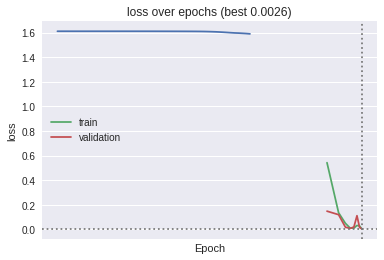

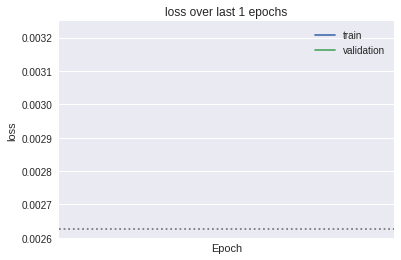

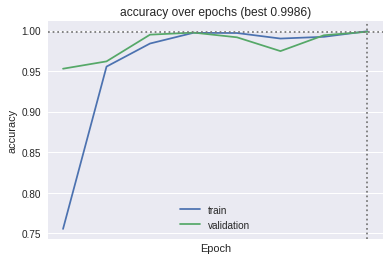

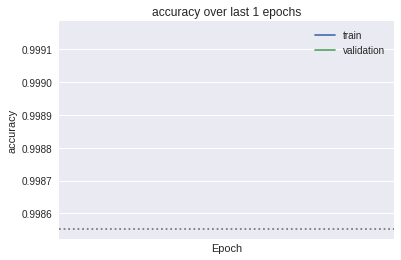


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 4ms/step - loss: 0.0041 - accuracy: 0.9989
Confusion matrix, without normalization
[[913   0   1]
 [  0 919   0]
 [  1   1 928]]

****** Validation data (unseen to model) *****

182/182 [==============================] - 1s 4ms/step - loss: 0.5346 - accuracy: 0.9406
Confusion matrix, without normalization
[[1815    0  126]
 [   0 1863   78]
 [   1  141 1799]]
Final Accuracy: 94.06 %

train : {'afib': 1609, 'nsr': 1637, 'afl': 399}
22766 18391 6728
After patient Scrambling: 20184


100%|██████████| 18391/18391 [00:00<00:00, 396035.64it/s]


test : {'afib': 170, 'nsr': 189, 'afl': 46}
2358 2129 763
After patient Scrambling: 2289


100%|██████████| 2129/2129 [00:00<00:00, 522264.20it/s]



#@#@#@#@#@ Working on FOLD: 7 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
388/388 [==============================] - 6s 14ms/step - loss: 0.4582 - accuracy: 0.8059 - val_loss: 0.1965 - val_accuracy: 0.9308
Epoch 2/8
388/388 [==============================] - 4s 12ms/step - loss: 0.1689 - accuracy: 0.9394 - val_loss: 0.2058 - val_accuracy: 0.9329
Epoch 3/8
388/388 [==============================] - 5s 12ms/step - loss: 0.0930 - accuracy: 0.9680 - val_loss: 0.1319 - val_accuracy: 0.9529
Epoch 4/8
388/388 [==============================] - 4s 11ms/step - loss: 0.0203 - accuracy: 0.9941 - val_loss: 0.0151 - val_accuracy: 0.9935
Epoch 5/8
388/388 [==============================] - 5s 12ms/step - loss: 0.0169 - accuracy: 0.9948 - val_loss: 0.0160 - val_accuracy: 0.9935
Epoch 6/8
388/388 [==============================] - 4s 11ms/step - loss: 0.0332 - accuracy: 0.9895 - val_loss: 0.1389 - val_accuracy: 0.9572
Epoch 7/8
388/388 [==============================] - 5s 12ms/step - loss: 0.0253 - accuracy: 0.9921 - val_loss: 0.0080 - val_accuracy: 0.9971
Epoch 

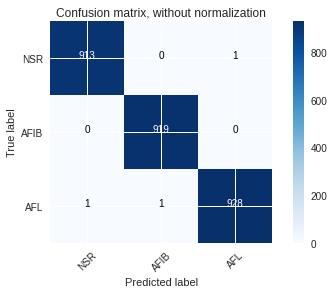

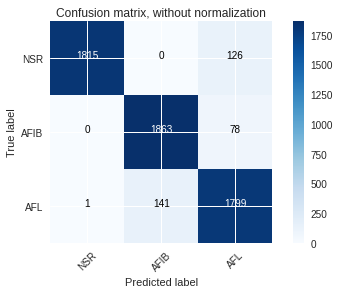

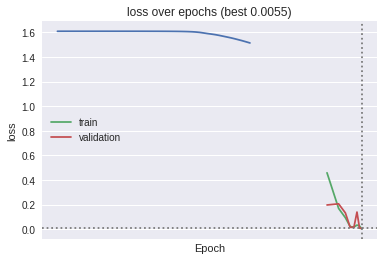

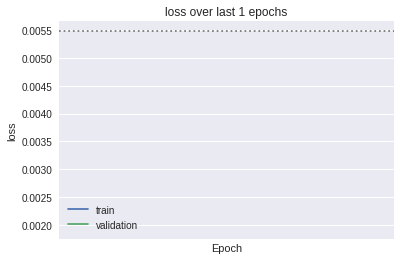

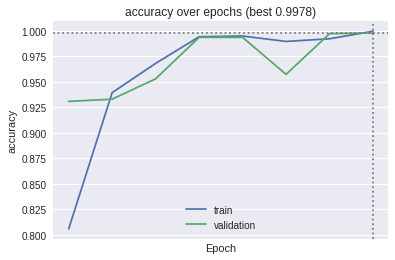

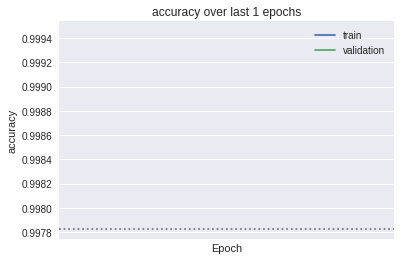


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 4ms/step - loss: 0.0034 - accuracy: 0.9986
Confusion matrix, without normalization
[[962   0   0]
 [  0 945   0]
 [  2   2 848]]

****** Validation data (unseen to model) *****

200/200 [==============================] - 1s 4ms/step - loss: 0.4004 - accuracy: 0.9266
Confusion matrix, without normalization
[[2110    0   19]
 [   0 2107   22]
 [   0  428 1701]]
Final Accuracy: 92.66 %

train : {'afib': 1597, 'nsr': 1635, 'afl': 413}
22521 18333 6937
After patient Scrambling: 20811


100%|██████████| 18333/18333 [00:00<00:00, 401697.68it/s]


test : {'afib': 182, 'nsr': 191, 'afl': 32}
2603 2187 554
After patient Scrambling: 1662


100%|██████████| 2187/2187 [00:00<00:00, 409195.83it/s]



#@#@#@#@#@ Working on FOLD: 8 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
387/387 [==============================] - 6s 14ms/step - loss: 0.5376 - accuracy: 0.7459 - val_loss: 0.1731 - val_accuracy: 0.9335
Epoch 2/8
387/387 [==============================] - 4s 12ms/step - loss: 0.1787 - accuracy: 0.9366 - val_loss: 0.1868 - val_accuracy: 0.9364
Epoch 3/8
387/387 [==============================] - 5s 12ms/step - loss: 0.0913 - accuracy: 0.9693 - val_loss: 0.0437 - val_accuracy: 0.9865
Epoch 4/8
387/387 [==============================] - 5s 13ms/step - loss: 0.0171 - accuracy: 0.9941 - val_loss: 0.0168 - val_accuracy: 0.9942
Epoch 5/8
387/387 [==============================] - 4s 11ms/step - loss: 0.0131 - accuracy: 0.9958 - val_loss: 0.0340 - val_accuracy: 0.9876
Epoch 6/8
387/387 [==============================] - 4s 12ms/step - loss: 0.0403 - accuracy: 0.9876 - val_loss: 0.0729 - val_accuracy: 0.9753
Epoch 7/8
387/387 [==============================] - 5s 12ms/step - loss: 0.0260 - accuracy: 0.9921 - val_loss: 0.0116 - val_accuracy: 0.9953
Epoch 

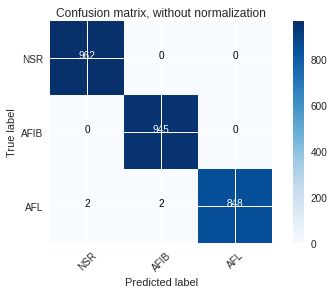

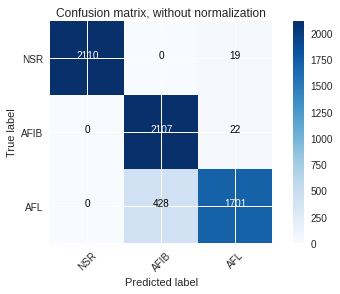

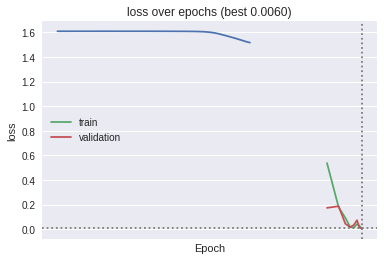

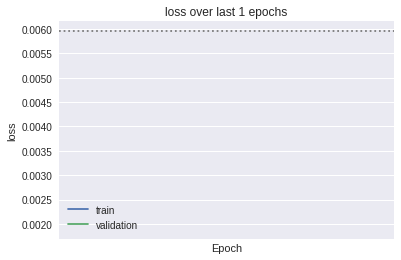

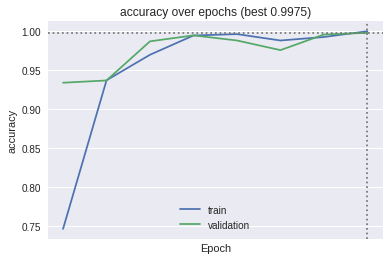

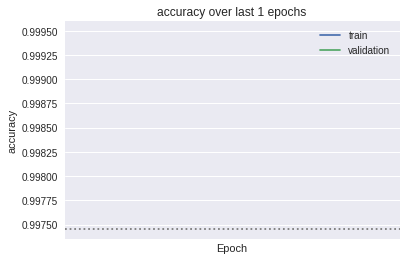


****** Val data (used to tune hyperparameters for model) *****

86/86 [==============================] - 0s 4ms/step - loss: 0.0029 - accuracy: 0.9996
Confusion matrix, without normalization
[[901   0   0]
 [  0 934   0]
 [  1   0 914]]

****** Validation data (unseen to model) *****

156/156 [==============================] - 1s 4ms/step - loss: 0.0660 - accuracy: 0.9848
Confusion matrix, without normalization
[[1662    0    0]
 [   0 1624   38]
 [   3   35 1624]]
Final Accuracy: 98.48 %

train : {'afib': 1606, 'nsr': 1646, 'afl': 393}
22685 18493 6640
After patient Scrambling: 19920


100%|██████████| 18493/18493 [00:00<00:00, 65261.35it/s]


test : {'afib': 173, 'nsr': 180, 'afl': 52}
2439 2027 851
After patient Scrambling: 2553


100%|██████████| 2027/2027 [00:00<00:00, 279924.08it/s]


#@#@#@#@#@ Working on FOLD: 9 #@#@#@#@#@




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
391/391 [==============================] - 6s 13ms/step - loss: 0.4247 - accuracy: 0.8178 - val_loss: 0.2341 - val_accuracy: 0.9149
Epoch 2/8
391/391 [==============================] - 5s 12ms/step - loss: 0.1350 - accuracy: 0.9514 - val_loss: 0.0750 - val_accuracy: 0.9758
Epoch 3/8
391/391 [==============================] - 5s 12ms/step - loss: 0.0466 - accuracy: 0.9842 - val_loss: 0.0434 - val_accuracy: 0.9874
Epoch 4/8
391/391 [==============================] - 5s 12ms/step - loss: 0.0070 - accuracy: 0.9978 - val_loss: 0.0040 - val_accuracy: 0.9989
Epoch 5/8
391/391 [==============================] - 4s 11ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.0081 - val_accuracy: 0.9960
Epoch 6/8
391/391 [==============================] - 4s 11ms/step - loss: 0.0256 - accuracy: 0.9915 - val_loss: 0.0236 - val_accuracy: 0.9910
Epoch 7/8
391/391 [==============================] - 5s 13ms/step - loss: 0.0165 - accuracy: 0.9944 - val_loss: 0.0027 - val_accuracy: 0.9993
Epoch 

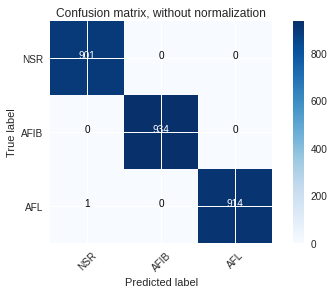

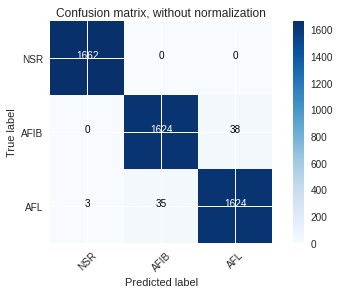

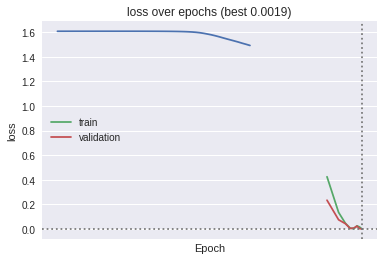

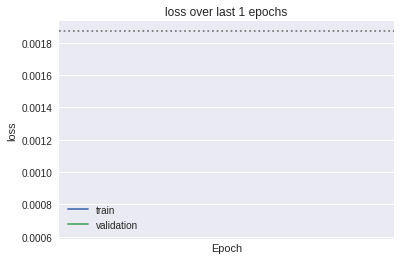

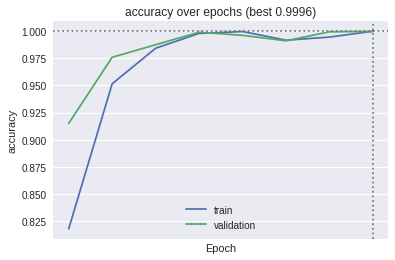

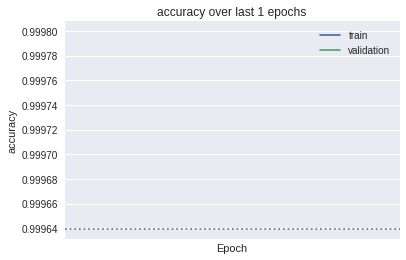


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 4ms/step - loss: 0.0011 - accuracy: 1.0000
Confusion matrix, without normalization
[[907   0   0]
 [  0 941   0]
 [  0   0 926]]

****** Validation data (unseen to model) *****

191/191 [==============================] - 1s 4ms/step - loss: 0.6410 - accuracy: 0.9369
Confusion matrix, without normalization
[[1952    0   75]
 [   0 1875  152]
 [   0  157 1870]]
Final Accuracy: 93.69 %

train : {'afib': 1608, 'nsr': 1642, 'afl': 395}
22727 18488 6628
After patient Scrambling: 19884


100%|██████████| 18488/18488 [00:00<00:00, 455593.50it/s]


test : {'afib': 171, 'nsr': 184, 'afl': 50}
2397 2032 863
After patient Scrambling: 2589


100%|██████████| 2032/2032 [00:00<00:00, 355458.39it/s]


#@#@#@#@#@ Working on FOLD: 10 #@#@#@#@#@




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
390/390 [==============================] - 6s 14ms/step - loss: 0.5174 - accuracy: 0.7595 - val_loss: 0.2130 - val_accuracy: 0.9225
Epoch 2/8
390/390 [==============================] - 5s 12ms/step - loss: 0.1633 - accuracy: 0.9404 - val_loss: 0.1375 - val_accuracy: 0.9499
Epoch 3/8
390/390 [==============================] - 5s 12ms/step - loss: 0.0754 - accuracy: 0.9739 - val_loss: 0.0259 - val_accuracy: 0.9913
Epoch 4/8
390/390 [==============================] - 5s 12ms/step - loss: 0.0075 - accuracy: 0.9977 - val_loss: 0.0049 - val_accuracy: 0.9993
Epoch 5/8
390/390 [==============================] - 5s 12ms/step - loss: 0.0063 - accuracy: 0.9981 - val_loss: 0.0246 - val_accuracy: 0.9899
Epoch 6/8
390/390 [==============================] - 5s 12ms/step - loss: 0.0388 - accuracy: 0.9869 - val_loss: 0.0185 - val_accuracy: 0.9935
Epoch 7/8
390/390 [==============================] - 4s 12ms/step - loss: 0.0147 - accuracy: 0.9955 - val_loss: 0.0057 - val_accuracy: 0.9982
Epoch 

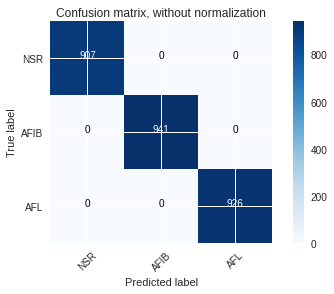

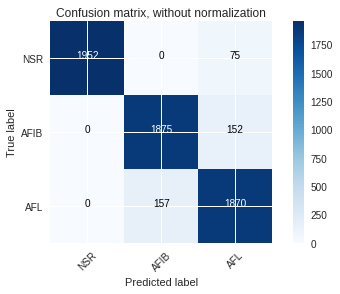

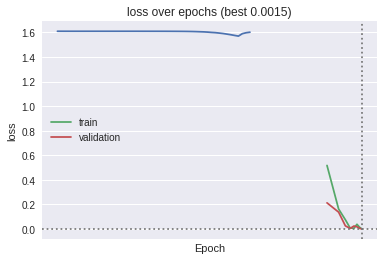

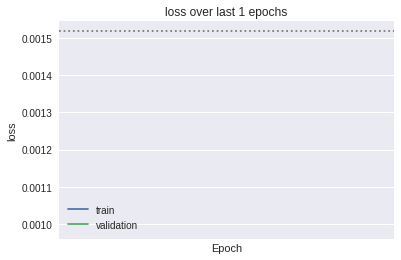

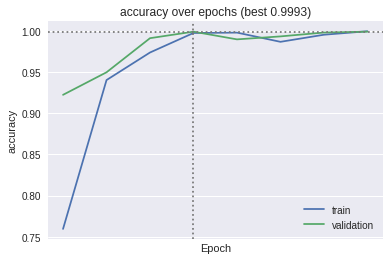

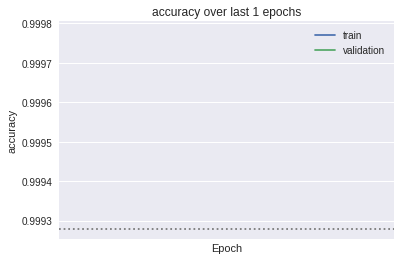


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 0.9996
Confusion matrix, without normalization
[[895   0   0]
 [  0 952   0]
 [  0   1 925]]

****** Validation data (unseen to model) *****

191/191 [==============================] - 1s 5ms/step - loss: 0.1538 - accuracy: 0.9662
Confusion matrix, without normalization
[[1928    0  104]
 [   0 1988   44]
 [   2   56 1974]]
Final Accuracy: 96.61999999999999 %

10 fold acc: [97.76, 96.24000000000001, 94.72, 95.98, 91.11, 94.06, 92.66, 98.48, 93.69, 96.61999999999999]


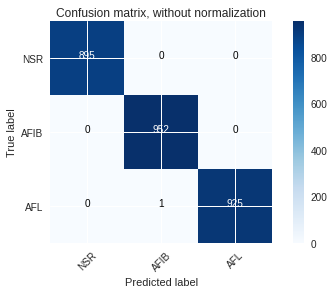

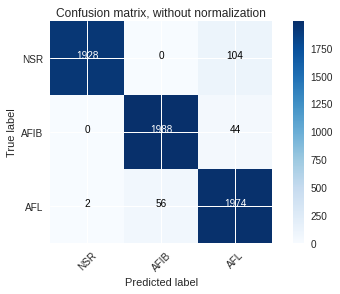

In [101]:
# scikit-learn k-fold cross-validation
data=all_subjects

# prepare cross validation
kfold = KFold(10,shuffle=True,random_state=42)
all_fold_acc = []
# enumerate splits
count=1
for train, test in kfold.split(data):  
  full_train_set = extractor("train",train)
  full_test_set = extractor("test",test)
  print("\n#@#@#@#@#@ Working on FOLD:",count,"#@#@#@#@#@\n")
  accuracy_1_fold = train_1_fold(full_train_set,full_test_set,5,8)
  all_fold_acc.append(accuracy_1_fold)
  count+=1
  #1 fold done call rest part in function to complete your k fold cv
  # break
print("10 fold acc:",all_fold_acc)

In [24]:
m_resnet_model = get_resnet_model(10)

m_resnet_model.load_weights("/content/drive/My Drive/Arrythmia /weights.hdf5")

In [ ]:
import glob

path = r'/content/musecare_rr_intervals' # use your path
all_files = glob.glob(path + "/*.csv")

li = []
name = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=None)
    one_list=df.iloc[0]
    new_df=pd.DataFrame()
    for i in range(0,len(one_list)):
      if(one_list[i]!=one_list[i+1]):
        one_list=one_list[i+1:i+101]
        one_list=one_list/1000
        one_list.reset_index(inplace=True,drop=True)
        detrended_rri = signal.detrend(one_list, axis= -1, type='constant', bp=0, overwrite_data=False).tolist()
        
        new_df=new_df.append(pd.DataFrame(detrended_rri).transpose())
        break
    li.append(new_df)
    name.append(filename)

test_data = pd.concat(li, axis=0, ignore_index=True)
test_data['filename']=name

print(test_data.shape[0] - test_data.dropna().shape[0])
#hence 81 files have null values, will drop them

test_data=test_data.dropna()
test_data.reset_index(inplace=True,drop=True)

X_ckecker=test_data.iloc[:,:-1].values
preds=tf.argmax(m_resnet_model.predict(X_ckecker), axis=-1)

test_data['predicted_class']=preds
dct= {0:'nsr', 1:'afib', 2:'afl'}
test_data=test_data.replace({"predicted_class": dct})
test_data['predicted_class'].value_counts()

In [ ]:
# test_data.to_csv("result_arr_ppg_RRi.csv",index=False)

### Testing on PTB Diagnostic ECG database

In [ ]:
# !wget "https://www.physionet.org/static/published-projects/ptbdb/ptb-diagnostic-ecg-database-1.0.0.zip"

--2022-04-06 09:13:40--  https://www.physionet.org/static/published-projects/ptbdb/ptb-diagnostic-ecg-database-1.0.0.zip
Resolving www.physionet.org (www.physionet.org)... 18.18.42.54
Connecting to www.physionet.org (www.physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1790456359 (1.7G) [application/zip]
Saving to: ‘ptb-diagnostic-ecg-database-1.0.0.zip.1’

    ptb-diagnostic-   3%[                    ]  63.44M  52.7MB/s               ^C


Each csv file includes information of 15 simultaneously measured signals:12 leads (i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5, v6) together with the 3 Frank lead ECGs (vx, vy, vz).
The sampling frequency of ECG is 1000Hz.

In [ ]:
!wget -r -N -c -np https://physionet.org/files/ptbdb/1.0.0/
!pip install wfdb
import wfdb #WaveForm-Database package. A library of tools for reading, writing, and processing WFDB signals and annotations.
import pandas as pd
import numpy as np
import sys
import glob
import os
from glob import glob
PATH = "/content/physionet.org/files/ptbdb/1.0.0/"
sys.path.append(os.path.abspath(PATH))

nsr_patients =['patient104/s0306lre','patient105/s0303lre','patient116/s0302lre','patient117/s0291lre','patient117/s0292lre',
      'patient121/s0311lre','patient122/s0312lre','patient131/s0273lre','patient150/s0287lre','patient155/s0301lre',
      'patient156/s0299lre','patient165/s0322lre','patient165/s0323lre','patient166/s0275lre','patient169/s0328lre',
      'patient169/s0329lre','patient170/s0274lre','patient172/s0304lre','patient173/s0305lre','patient174/s0300lre',
      'patient174/s0324lre','patient174/s0325lre','patient180/s0374lre','patient180/s0475_re','patient180/s0476_re',
      'patient180/s0477_re','patient180/s0490_re','patient180/s0545_re','patient180/s0561_re','patient182/s0308lre',
      'patient184/s0363lre','patient185/s0336lre','patient198/s0402lre','patient198/s0415lre','patient214/s0436_re',
      'patient229/s0452_re','patient229/s0453_re','patient233/s0457_re','patient233/s0458_re','patient233/s0459_re',
      'patient233/s0482_re','patient233/s0483_re','patient234/s0460_re','patient235/s0461_re','patient236/s0462_re',
      'patient236/s0463_re','patient236/s0464_re','patient237/s0465_re','patient238/s0466_re','patient239/s0467_re',
      'patient240/s0468_re','patient241/s0469_re','patient241/s0470_re','patient242/s0471_re','patient243/s0472_re',
      'patient244/s0473_re','patient245/s0474_re','patient245/s0480_re','patient246/s0478_re','patient247/s0479_re',
      'patient248/s0481_re','patient251/s0486_re','patient251/s0503_re','patient251/s0506_re','patient252/s0487_re',
      'patient255/s0491_re','patient260/s0496_re','patient263/s0499_re','patient264/s0500_re','patient266/s0502_re',
      'patient267/s0504_re','patient276/s0526_re','patient277/s0527_re','patient279/s0531_re','patient279/s0532_re',
      'patient279/s0533_re','patient279/s0534_re','patient284/s0543_re','patient284/s0551_re','patient284/s0552_re']

In [26]:
files = nsr_patients

for i in tqdm(range(0,len(files))):
	recordname=PATH+str(files[i])+'.hea'
	
	recordname_new=recordname[-23:-4] #Extracting just the filename part (will differ from database to database)
	# print(recordname_new)
	record = wfdb.rdsamp(PATH+recordname_new) # rdsamp() returns the signal as a numpy array  
	record=np.asarray(record[0])
	path=PATH+recordname_new+".csv"
	np.savetxt(path,record,delimiter=",") #Writing the CSV for each record
	
print("\nAll files done!")

100%|██████████| 80/80 [02:09<00:00,  1.62s/it]


All files done!


In [102]:
methods=["interpolation","FFT","poly","numpy"]
m_resnet_model = get_resnet_model(5)
m_resnet_model.load_weights("/content/drive/My Drive/Arrythmia /weights.hdf5")
for way in methods:
  print("Using",way,"method of Resampling\n")
  filenames=[]
  li=[]
  for i in tqdm(range(0,len(files))):
    recordname=PATH+str(files[i])+'.csv'
    df=pd.read_csv(recordname,header=None)
    lead_II = df.iloc[:,1] #lead II
    lead_II = nk.signal_resample(lead_II, method=way,
                                              sampling_rate=1000, desired_sampling_rate=500)
    _, rpeaks = nk.ecg_peaks(lead_II, sampling_rate=500)
    rrintervals = rpeaks['ECG_R_Peaks']

    rr_diff=np.diff(rrintervals)/1000
    detrended_rri = signal.detrend(rr_diff, axis= -1, type='constant', bp=0, overwrite_data=False)
    new_df=pd.DataFrame(detrended_rri).transpose()
    li.append(new_df)
    filenames.append(files[i])
    
  test_data = pd.concat(li, axis=0, ignore_index=True)
  test_data=test_data.loc[:,:99]
  test_data['filename']=filenames 

  print("Dropping:",test_data.shape[0] - test_data.dropna().shape[0]," rows.\n")
  #hence 81 files have null values, will drop them
 
  test_data=test_data.dropna()
  test_data.reset_index(inplace=True,drop=True)

  X_ckecker=test_data.iloc[:,:-1].values
  preds=tf.argmax(m_resnet_model.predict(X_ckecker), axis=-1)

  test_data['predicted_class']=preds
  dct= {0:'nsr', 1:'Afib',2:'Afl'}
  test_data=test_data.replace({"predicted_class": dct})
  print("#### RESULTS ####\n",test_data['predicted_class'].value_counts(),"\n")

Using interpolation method of Resampling



100%|██████████| 80/80 [00:30<00:00,  2.62it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     56
Afl     11
Afib    11
Name: predicted_class, dtype: int64 

Using FFT method of Resampling



100%|██████████| 80/80 [00:30<00:00,  2.64it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     55
Afl     12
Afib    11
Name: predicted_class, dtype: int64 

Using poly method of Resampling



100%|██████████| 80/80 [00:29<00:00,  2.67it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     55
Afl     12
Afib    11
Name: predicted_class, dtype: int64 

Using numpy method of Resampling



100%|██████████| 80/80 [00:29<00:00,  2.68it/s]

Dropping: 2  rows.

#### RESULTS ####
 nsr     55
Afl     12
Afib    11
Name: predicted_class, dtype: int64 

